# STAT 628 Module 1: Body Fat Percentage Predictions
### Group 6

## Introduction and Motivation

The body fat percentage (BFP) of a human is a value that tells you how much of your body weight is made up of fat.

If the body fat percentage is too low, our energy levels and resistance to diseases are lower. However, if the body fat percentage is too high, we may have a higher risk of diabetes and other health problems. In terms of overall health, body fat percentage may be an important number for us.

Unlike height and weight, BFP cannot be measured easily and directly. Therefore, the goal of this project is to develop a simple rule of thumb technique for estimating the body fat percentage using only measurements which can be easily obtained. In addition to being simple, we wish for our estimator to be robust, accurate, and precise. This means it should give reasonably accurate predictions for most people, and its predictions for outliers should not be extremely unreasonable.

## Data Description

The dataset contains 252 observations of 16 features, such as:

* $BODYFAT$ (%)
* $DENSITY$ (gm/cm$^{3}$)
* $AGE$ (years)
* $WEIGHT$ (lbs)

Among these features, $DENSITY$ is measured accurately from underwater weighing and $BODYFAT$ is obtained by Siri's equation, which is a linear relation between body fat percentage and density:

$B = \frac{495}{D} - 450$.

(Note: B is the percentage of body fat,D is body density.)

## Concerns With Linear Regression Model

We choose to use simple linear regression model as our final model. There are several important assumptions about linear regression:

1. **Linear relationship**: We will check linear relationship between $BODYFAT$ and each covariate after outlier detection. 

2. **Multivariate normality**: We will use Q-Q plot to check this assumption.

3. **Homoscedasticity**: We will use diagnostic plot to check this assumption

4. **Error term independence**: We will use diagnostic plots to check this assumption.

5. **Multicollinearity**: We use Variance Inflation Factor to check multicollinearity. Since our goal is prediction, we do not need to worry too much about this.

6. **Sensitive to outliers**: During data cleaning, we draw a linear relationship diagnostic plot to detect outliers.

## Data cleaning

Linear regression is sensitive to outliers, so we detect outliers by two different ways. First, we use Siri's equation since we know there should be a linear relation between $BODYFAT$ and $DENSITY$.

In [1]:
# Packages
suppressPackageStartupMessages(library(tidyverse))
library(ggplot2)
suppressPackageStartupMessages(library(glmnet))
library(leaps)
set.seed(628)

# Open dataset
dat <- suppressMessages(read_csv("data/BodyFat.csv"))

# Root MSE calculator
root.mse <- function(y, yhat) {
    return(sqrt(mean((y - yhat) ^ 2)))
}

# Siri's equation for calculating body fat percentage from density
siri <- function(density) {
    return(495 / density - 450)
}

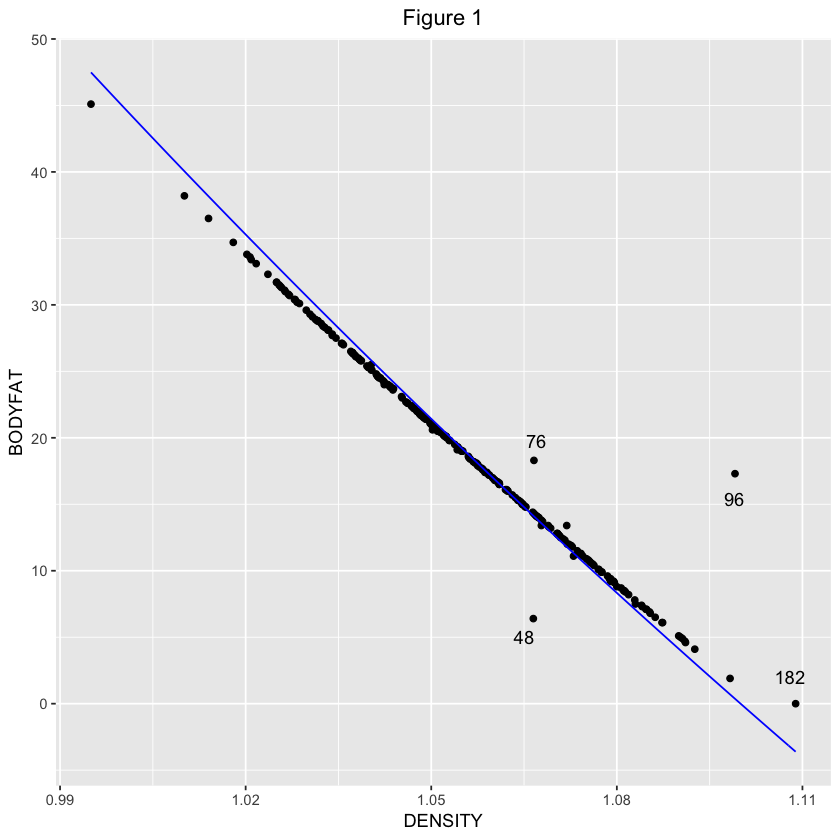

In [2]:
############
# Outliers #
############

# Examine the difference between BODYFAT and values calculated with Siri's eq.
fig1 <- ggplot(dat, aes(DENSITY, BODYFAT)) + geom_point() +
  stat_function(fun = siri, n = 101, color = "blue") +
  annotate("text", 1.065, 5, label = as.numeric(which(
    dat$DENSITY < 1.07 & dat$DENSITY > 1.06 & dat$BODYFAT > 5 & dat$BODYFAT < 10))) +
  annotate("text", 1.099, 15.4, label = as.numeric(which(
    dat$DENSITY < 1.11 & dat$DENSITY > 1.09 & dat$BODYFAT > 15 & dat$BODYFAT < 20))) +
  annotate("text", 1.108, 2, label = as.numeric(which(
    dat$DENSITY > 1.1 & dat$BODYFAT < 5))) +
  annotate("text", 1.067, 19.8, label = as.numeric(which(
    dat$DENSITY < 1.07 & dat$DENSITY > 1.06 & dat$BODYFAT > 18 & dat$BODYFAT < 20))) +
  labs(title = "Figure 1") + theme(plot.title = element_text(hjust = 0.5))
plot(fig1)

From Figure 1, three records 48, 96, 182，76 seem abnormal.

In [3]:
# Look at abnomal points to see if they should be deleted
dat[c(48,96,182,76),]

IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
48,6.4,1.0665,39,148.50,71.25,20.6,34.6,89.8,79.5,92.7,52.7,37.5,21.9,28.8,26.8,17.9
96,17.3,1.0991,53,224.50,77.75,26.1,41.1,113.2,99.2,107.5,61.7,42.3,23.2,32.9,30.8,20.4
182,0.0,1.1089,40,118.50,68.00,18.1,33.8,79.3,69.4,85.0,47.2,33.5,20.2,27.7,24.6,16.5
76,18.3,1.0666,61,148.25,67.50,22.9,36.0,91.6,81.8,94.8,54.5,37.0,21.4,29.3,27.0,18.3


* **48**: The BODYFAT calculated by DENSITY is about 14.1%, but 6.4% seems to be a possible value so we just keep this value. Then we build a linear regression model to detect whether this is an outlier by Cook's distance.
* **96**: The BODYFAT calculated by DENSITY is about 0.37%, which is extremely small, but other measurements are quite normal. So we think the value of DENSITY may be a wrong record and we keep the original BODYFAT value.
* **182**: We think 0% of bodyfat is impossible, and the BODYFAT calculated by DENSITY iS negative, so we regard this as a wrong record and directly delete it.
* **76**: The BODYFAT calculated by DENSITY IS about 14.1%, but 18.3% seems possible because this person is 61 years old and older people may have higher percentage of fat so we keep this value. 

In [4]:
# Drop observation 182 which has zero bodyfat
dat <- dat[dat$IDNO != 182,]

The second method we use is to build a linear regression model to detect outliers by looking at Cook's distance. We first delete the $IDNO$ and $DENSITY$ features since we do not want them to be used as regressors in our model.

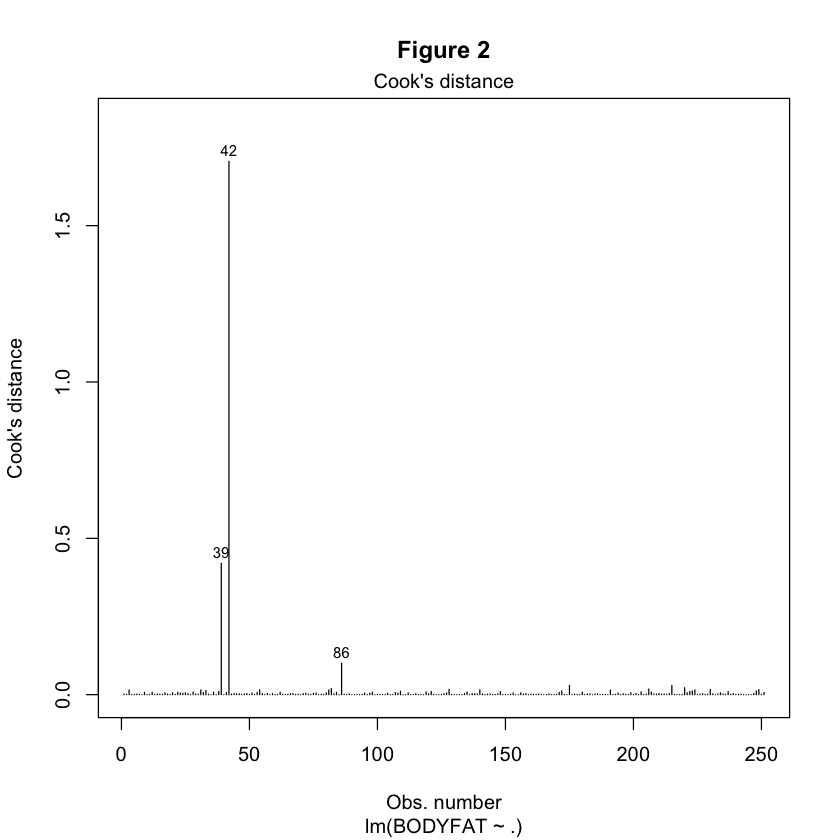

In [5]:
# Look at Cook's distance
dat <- subset(dat, select = -c(DENSITY, IDNO))
plot(lm(BODYFAT ~ ., dat), which = 4, main = "Figure 2")

In [6]:
# Look at abnomal points to see if they should be deleted
dat[c(39,42,86),]

BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
33.8,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
31.7,44,205.00,29.50,29.9,36.6,106.0,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4
25.8,67,167.00,67.50,26.0,36.5,98.9,89.7,96.2,54.7,37.8,33.7,32.4,27.7,18.2


* **39**: It's a trade-off for us to decide whether to keep such a fat person in our model. We want our method to be precise and robust, which means we want our calculator to have good performance for data drawn from a wide range of probability distributions, especially for distributions that are not normal. We will first keep this and show the reasons later.
* **42**: The $HEIGHT$ is 29.50 inches, which is almost certainly an erroneous record, so we remove this observation.
* **86**: All the measurements seem reasonable, so we leave it in the dataset.

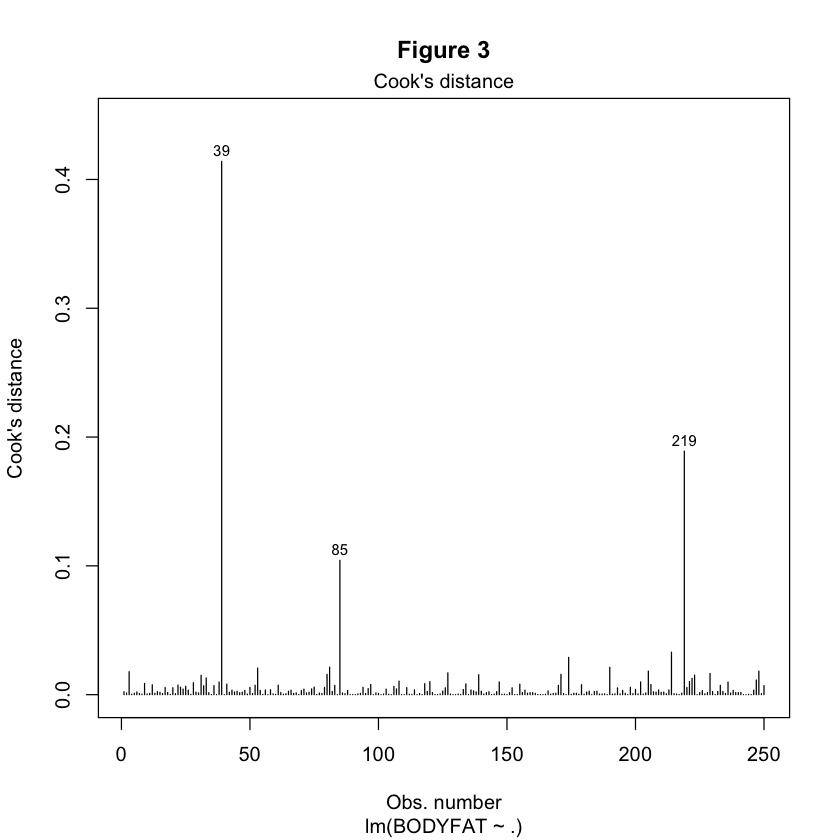

In [7]:
# Drop observation 42
dat <- dat[-42,]
plot(lm(BODYFAT ~ ., dat), which = 4, main="Figure 3")

Although there are still some abnormal points after removing 42nd and 128th points, we do not have enough reason to delete them from the dataset.

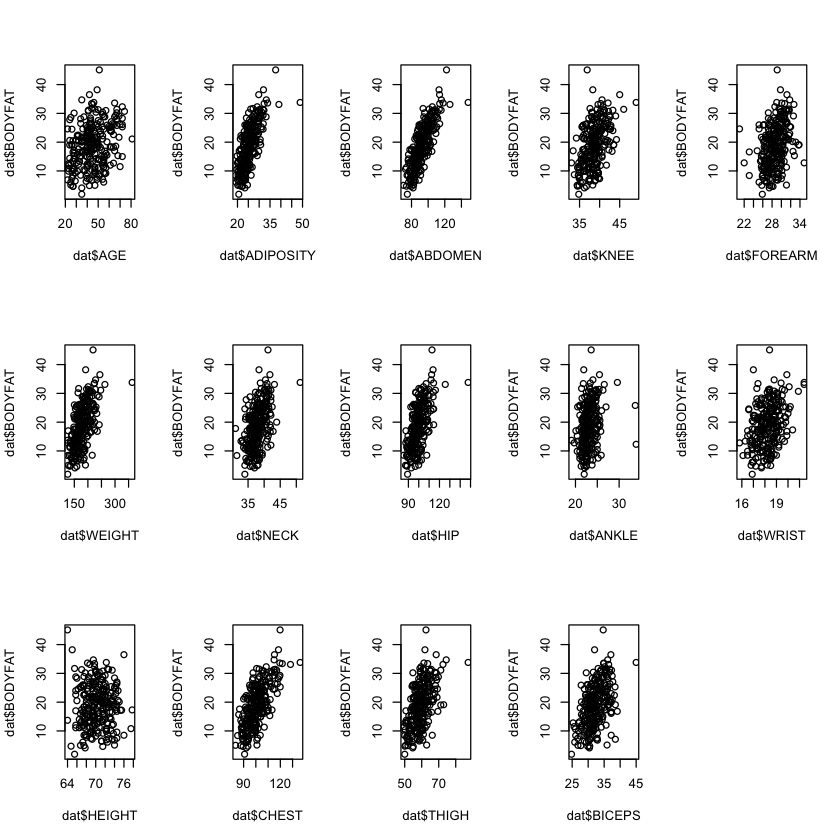

In [8]:
#############################
# Linear relationship check #
#############################

layout(matrix(seq(1,15),nrow=3))
plot(dat$AGE, dat$BODYFAT)
plot(dat$WEIGHT, dat$BODYFAT)
plot(dat$HEIGHT, dat$BODYFAT)
plot(dat$ADIPOSITY, dat$BODYFAT)
plot(dat$NECK, dat$BODYFAT)
plot(dat$CHEST, dat$BODYFAT)
plot(dat$ABDOMEN, dat$BODYFAT)
plot(dat$HIP, dat$BODYFAT)
plot(dat$THIGH, dat$BODYFAT)
plot(dat$KNEE, dat$BODYFAT)
plot(dat$ANKLE, dat$BODYFAT)
plot(dat$BICEPS, dat$BODYFAT)
plot(dat$FOREARM, dat$BODYFAT)
plot(dat$WRIST, dat$BODYFAT)
layout(1)

By checking the above scatterplots between $BODYFAT$ and each covariate, we conclude that the linear relationship assumption is satisfied.

## Variable Selection

To keep our model simple, we want to select at most four features for our final estimator. In order to identify the most predictive features, we use two methods:

* Stepwise variable selection based on AIC and BIC criteria

* LASSO regression

After identifying the most useful variables, we use best subset selection to find the best features for a model containing $p=1,2,3,4$ variables. Best subset selection is more computationally intensive, so it's better to use it after we've alrady narrowed our feature space to a few variables.

### Stepwise Selection

First, we perform stepwise variable selection to try and find a small number of important features. This is done using bidirectional steps with both AIC and BIC.

In [9]:
######################
# Stepwise selection #
######################

lm.max <- lm(BODYFAT ~ ., data = dat)
lm.min <- lm(BODYFAT ~ 1, data = dat)
scope <- list(lower=lm.min, upper=lm.max)

# AIC
lm1 <- step(object = lm.max, scope = scope, direction = "both",
            trace = 0, k = 2) # K=2->AIC, K=log(n)->BIC
lm2 <- step(object = lm.min, scope = scope, direction = "both",
            trace = 0, k = 2) # K=2->AIC, K=log(n)->BIC

# BIC
lm3 <- step(object = lm.max, scope = scope, direction = "both",
            trace = 0, k = log(dim(dat)[1]))
lm4 <- step(object = lm.min, scope = scope, direction = "both",
            trace = 0, k = log(dim(dat)[1]))

# Found models
cat("AIC stepwise starting with full model results in:")
summary(lm1)$call
cat("\n\nAIC stepwise starting with empty model results in:")
summary(lm2)$call
cat("\n\nBIC stepwise starting with full model results in:")
summary(lm3)$call
cat("\n\nBIC stepwise starting with empty model results in:")
summary(lm4)$call

AIC stepwise starting with full model results in:

lm(formula = BODYFAT ~ AGE + WEIGHT + NECK + ABDOMEN + HIP + 
    THIGH + FOREARM + WRIST, data = dat)



AIC stepwise starting with empty model results in:

lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + FOREARM + NECK + 
    BICEPS + AGE, data = dat)



BIC stepwise starting with full model results in:

lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + FOREARM + WRIST, data = dat)



BIC stepwise starting with empty model results in:

lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + FOREARM, data = dat)

As can be seen above, the AIC criterion tends to result in models which are too large. However, BIC results in a model containing only $ABDOMEN$, $WEIGHT$, $WRIST$, and $FOREARM$.

### LASSO Regression

Next, we use LASSO regression to find a sufficiently sparse model.

In [10]:
###################
# Lasso selection #
###################

# Feature matrix
lasso.dat <- as.matrix(subset(dat, select = -BODYFAT))

# Cross-validated selection of lambda
cv.lasso1 <- cv.glmnet(x = lasso.dat, y = dat$BODYFAT, 
                       type.measure = 'mse', alpha = 1)

# Best lambda for each model size
lasso.results <- data.frame(p = cv.lasso1$glmnet.fit$df,
                            explained = cv.lasso1$glmnet.fit$dev.ratio,
                            lambda = cv.lasso1$glmnet.fit$lambda)
print(lasso.results[c(18, 21, 25, 33, 34, 41, 43, 45),])

# Lasso regression using a specific lambda value chosen from above
m1 <- glmnet(lasso.dat, dat$BODYFAT, lambda = 0.314500, alpha = 1)

# Standard error of the above model `m1`
cat("\nRoot MSE for lambda=0.3145: ",
    root.mse(dat$BODYFAT, predict(m1, lasso.dat))) # = 4.132473

   p explained    lambda
18 1 0.6268050 1.2695568
21 2 0.6499567 0.9603731
25 3 0.6718085 0.6619479
33 4 0.7066976 0.3144789
34 5 0.7089458 0.2865415
41 6 0.7243139 0.1494030
43 7 0.7270046 0.1240370
45 8 0.7295459 0.1029777

Root MSE for lambda=0.3145:  4.132473

The above table lists the $\lambda$-value which minimizes the root mean-squared error for a model containing $p=1,...,8$ features. Choosing the LASSO regression with 4 terms results in a root MSE of 4.13. The features contained in this regression are $AGE$, $HEIGHT$, $ABDOMEN$, and $WRIST$.

### Best Subset Selection

Stepwise selection and LASSO regression identified 6 variables in total:

$ABDOMEN$, $WRIST$, $WEIGHT$, $FOREARM$, $AGE$, $HEIGHT$

We next perform best subset selection (BSS) to determine which of these variables should be included in a model with $p=1,2,3,4$ variables.

In [11]:
#########################
# Best Subset Selection #
#########################

# Using the 6 identified features above, perform best subset selection

# Feature matrix containing WEIGHT, ABDOMEN, FOREARM, WRIST, AGE, HEIGHT
dat.6vars <- as.matrix(
  subset(dat, select = c(WEIGHT, ABDOMEN, FOREARM, WRIST, AGE, HEIGHT)))

# Best subset selection
best.subset <- regsubsets(x = dat.6vars, y = dat$BODYFAT, nvmax = 4,
                          method = 'exhaustive')
summary(best.subset)$outmat

,WEIGHT,ABDOMEN,FOREARM,WRIST,AGE,HEIGHT
1 ( 1 ),,*,,,,
2 ( 1 ),*,*,,,,
3 ( 1 ),*,*,,*,,
4 ( 1 ),*,*,*,*,,


The results of BSS are displayed above. We can see that the results for a 4-variable model are the same as those from our stepwise selection process using the BIC criterion.

Now, we run an OLS regression for each of these four models and assess the standard error of their fits.

In [12]:
# OLS regressions for p=1,2,3,4 features
summary(lm(BODYFAT ~ ABDOMEN, dat))$sigma
summary(lm(BODYFAT ~ ABDOMEN + WEIGHT, dat))$sigma
summary(lm(BODYFAT ~ ABDOMEN + WEIGHT + WRIST, dat))$sigma
summary(lm(BODYFAT ~ ABDOMEN + WEIGHT + WRIST + FOREARM, dat))$sigma

[1] 4.503486

[1] 4.110271

[1] 4.0574

[1] 4.011768

A 2-variable model is a solid improvement over a 1-variable model, but the improvements from adding a $3^{rd}$ or $4^{th}$ variable are small. This leads us to conclude that a 2-variable model containing $ABDOMEN$ and $WEIGHT$ is the best balance between accuracy and simplicity.

## Final Model

Our final model takes the form:

$BODYFAT = \beta_0 + \beta_1 ABDOMEN + \beta_2 WEIGHT$

The coefficient estimates are shown below.

In [13]:
#################
# Model Fitting #
#################

# Final linear model:
bodyfat.model <- lm(dat$BODYFAT ~ dat$ABDOMEN + dat$WEIGHT)
as.data.frame(coef(bodyfat.model))

,coef(bodyfat.model)
(Intercept),-40.6965345
dat$ABDOMEN,0.9086988
dat$WEIGHT,-0.1367529


## Rule of Thumb

We can simplify this model into the following rule of thumb:

$ BODYFAT = 0.91\cdot ABDOMEN - 0.14\cdot WEIGHT - 41$

This formula is not difficult to memorize and can be evaluated with a calculator in a few seconds, so we are content with its simplicity. Moreoever, it is still precise:

In [14]:
#################
# Rule of Thumb #
#################

# Exact model predictions
bodyfat.model.yhat <- predict(bodyfat.model, dat)

# Simplified rule of thumb predictions
rot.yhat <- 0.91 * dat$ABDOMEN - 0.14 * dat$WEIGHT - 41

# Exact vs. rule of thumb accuracy
cat('Standard error of exact model:   ', root.mse(dat$BODYFAT, bodyfat.model.yhat))
cat('\nStandard error of rule of thumb: ', root.mse(dat$BODYFAT, rot.yhat))

Standard error of exact model:    4.085535
Standard error of rule of thumb:  4.157249

## Model Evaluation and Diagnostics

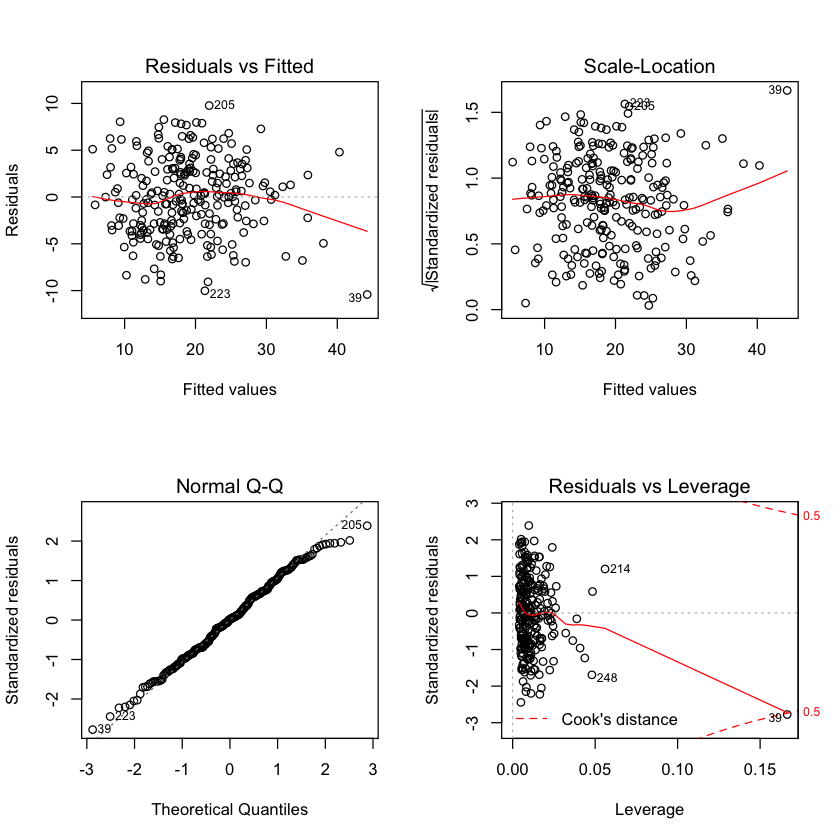

In [15]:
####################################
# Model Evaluation and Diagnostics #
####################################

# Model diagnostic plots
layout(matrix(c(1,2,3,4), nrow = 2))
plot(bodyfat.model)

From the plot of fitted values versus residuals, we can conclude that the linear assumption is satisfied. The error terms are independent and have equal variance. The Q-Q plot shows that the error terms approximately follow a normal distribution.

However, the leverage plot shows that the 39th point is an outlier. In order to determine whether or not this point should be removed, we decided to evaluate the trade-off between robustness and precision in our model when the point is removed and kept.

We fit our final model with and without 39th point to see how much the coefficients changed:


Call:
lm(formula = rodata$BODYFAT ~ rodata$ABDOMEN + rodata$WEIGHT)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.0573  -2.9614  -0.1035   2.9452   9.9097 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -42.28955    2.45945  -17.20  < 2e-16 ***
rodata$ABDOMEN   0.90011    0.05179   17.38  < 2e-16 ***
rodata$WEIGHT   -0.12314    0.01955   -6.30 1.36e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.054 on 246 degrees of freedom
Multiple R-squared:  0.718,	Adjusted R-squared:  0.7157 
F-statistic: 313.2 on 2 and 246 DF,  p-value: < 2.2e-16



Call:
lm(formula = dat$BODYFAT ~ dat$ABDOMEN + dat$WEIGHT)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.4199  -2.9618   0.0398   2.9543   9.7707 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -40.69653    2.42680 -16.770  < 2e-16 ***
dat$ABDOMEN   0.90870    0.05242  17.336  < 2e-16 ***
dat$WEIGHT   -0.13675    0.01920  -7.122 1.16e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.11 on 247 degrees of freedom
Multiple R-squared:  0.7133,	Adjusted R-squared:  0.711 
F-statistic: 307.3 on 2 and 247 DF,  p-value: < 2.2e-16


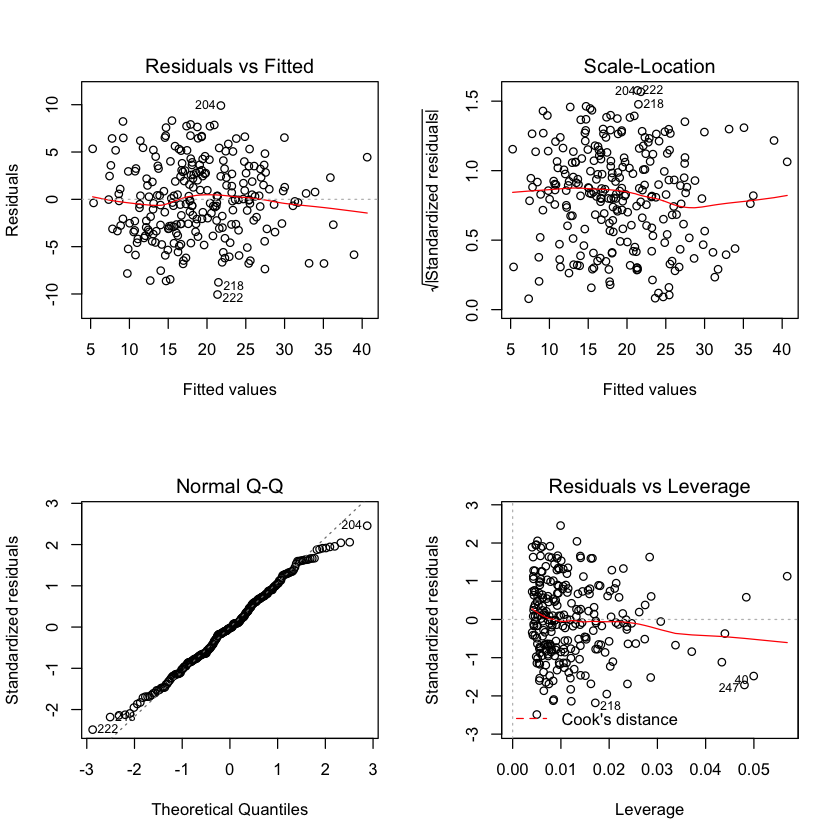

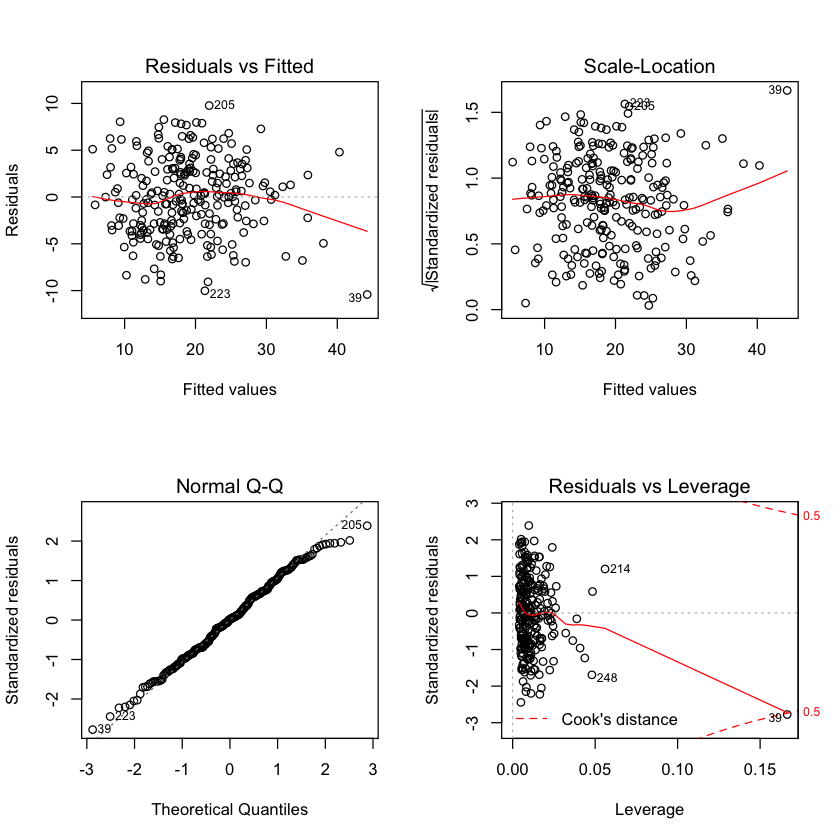

In [16]:
# Seem that 39th point is an outlier, so we decided to evaluate the robustness of our model:
rodata <- dat[-39,]
without <- lm(rodata$BODYFAT ~ rodata$ABDOMEN + rodata$WEIGHT)
summary(without)
summary(bodyfat.model)
layout(matrix(c(1,2,3,4), nrow = 2))
plot(without)
layout(matrix(c(1,2,3,4), nrow = 2))
plot(bodyfat.model)

This shows a trade-off between robustness and precison. Removing the 39th point does make our final model more accurate and this can be measured from the residual standard error (which is about 0.056 better when the point is removed).

However, we want our model to be robust; that is, we want it to be useful for a wide range of individuals. The inclusion or exclusion of the 39th point does not seem to affect the coefficients much, which indicates that our model is relatively robust to outliers. Since point 39 does not appear to be an error, we will keep it in the dataset and regard this as our final model.

## Conclusion

Our final rule of thumb is:

$ BODYFAT = 0.91\cdot ABDOMEN - 0.14\cdot WEIGHT - 41$

This estimator is easy to understand and can be quickly computed since it only uses two variables. It is robust to outlier individuals and provides relatively precise estimates of body fat percentage.

However, it does have a few drawbacks. First, it can only be used for males since the dataset only includes male observations. In addition, because it is a very simple model, it will not be as precise as a model which includes many variables or considers nonlinear relationships between BFP and the features. Nonetheless, we still believe that the advantages of having a simple and easy-to-use rule of thumb outweight these disadvantages.